# September sampling analysis 

trial of using September for training and testing periods ... 3 methods used: split, fixed random sampling, and "classic" random sampling

### import necessary modules 

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, date
import glob,os
import time
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

#### import functions I've written and that are locally stored

In [27]:
import sys
sys.path.append("/home/ehojeily/scripts/functions/")
from calibrate import calibrate
from generate_coefficients import generate_coefficients

### import proto 2 data 

In [28]:
path_corrected_proto2='despiked_proto2/'
proto2_corrected_filepaths=[]
for file in sorted(os.listdir(path_corrected_proto2)):
    if file != '.ipynb_checkpoints':
        proto2_corrected_filepaths.append(path_corrected_proto2+file)
    
proto2_corrected_from_files=(pd.read_csv(f,on_bad_lines='skip') for f in proto2_corrected_filepaths)
proto2_corrected=pd.concat(proto2_corrected_from_files)
times=pd.to_datetime(proto2_corrected['Unnamed: 0'],format='%Y-%m-%d %H:%M:%S')
proto2_corrected=proto2_corrected.set_index(times)
proto2_corrected.index.names=['date']
proto2_corrected=proto2_corrected.drop('Unnamed: 0',1)
#take high frequency proto2 data and resample to hourly mean
houravg=proto2_corrected.drop(columns=['datetimestamp']).apply(pd.to_numeric).resample('60min').mean()
houravg;

### import dec reference data 

In [29]:
path_epa='/data/aq/DEC/csv/'
epa_filepaths=[]
for file in sorted(os.listdir(path_epa)):
    epa_filepaths.append(path_epa+file)
    
epa_from_files=(pd.read_csv(f) for f in epa_filepaths)
epa_df=pd.concat(epa_from_files)
epa_df=epa_df.set_index(pd.to_datetime(epa_df['date']))
epa_table={42101:'Trace CO (ppb)',44201:'O3 (ppb)',42601:'NOx (ppb)',42602:'NO2 (ppb)',88101:'PM25FEM (ug/m3)'}

## preparing data 

### we need to correct data for timezones and NaN values

#### .. timezone corrections

In [30]:
houravg = houravg.tz_localize(tz='UTC') # proto 2 is in UTC

In [31]:
epa_df = epa_df.tz_localize(tz='EST') # DEC is in est
epa_df = epa_df.tz_convert('UTC') # convert to UTC

#### .. match epa to proto2

In [32]:
# keep only DEC data that matches Proto2 data 
epa_df_matching_proto2=epa_df.loc[epa_df.index.isin(houravg.index)]
epa_df_matching_proto2;
#set dictionary that matches varid to field name
proto2_table={'42101':'CO_ppb','44201':'O3NO2_ppb','42601':'NO_ppb','42602':'NO2_ppb','88101':'pm25'}
epa_table={42101:'Trace CO (ppb)',44201:'O3 (ppb)',42601:'NOx (ppb)',42602:'NO2 (ppb)',88101:'PM25FEM (ug/m3)'}

#### .. choose only september data 

In [33]:
#september = (epa_df_matching_proto2['date'] >= '2021-09-01  00:00:00') & (epa_df_matching_proto2['date'] <= '2021-09-31 23:00:00') 
DEC_sept = epa_df_matching_proto2.loc['2021-09-01 00:00:00+00:00':'2021-09-30 23:00:00+00:00']
proto2_sept = houravg.loc[DEC_sept.index]

#### .. assessing data completeness 

In [34]:
# count how many NaN values in DEC ref DF
DEC_sept.isna().sum()

date                0
O3 (ppb)            0
Trace CO (ppb)     16
NO (ppb)           21
NO2 (ppb)          21
NOx (ppb)          21
PM25FEM (ug/m3)    86
TEMP (Deg F)        0
SO2T (ppb)         10
O3.1 (ppm)         18
dtype: int64

In [35]:
# count how many NaN values in proto2 DF
proto2_sept.isna().sum();
# no NaN in proto2 

#### .. plot DEC data to visualize completeness 

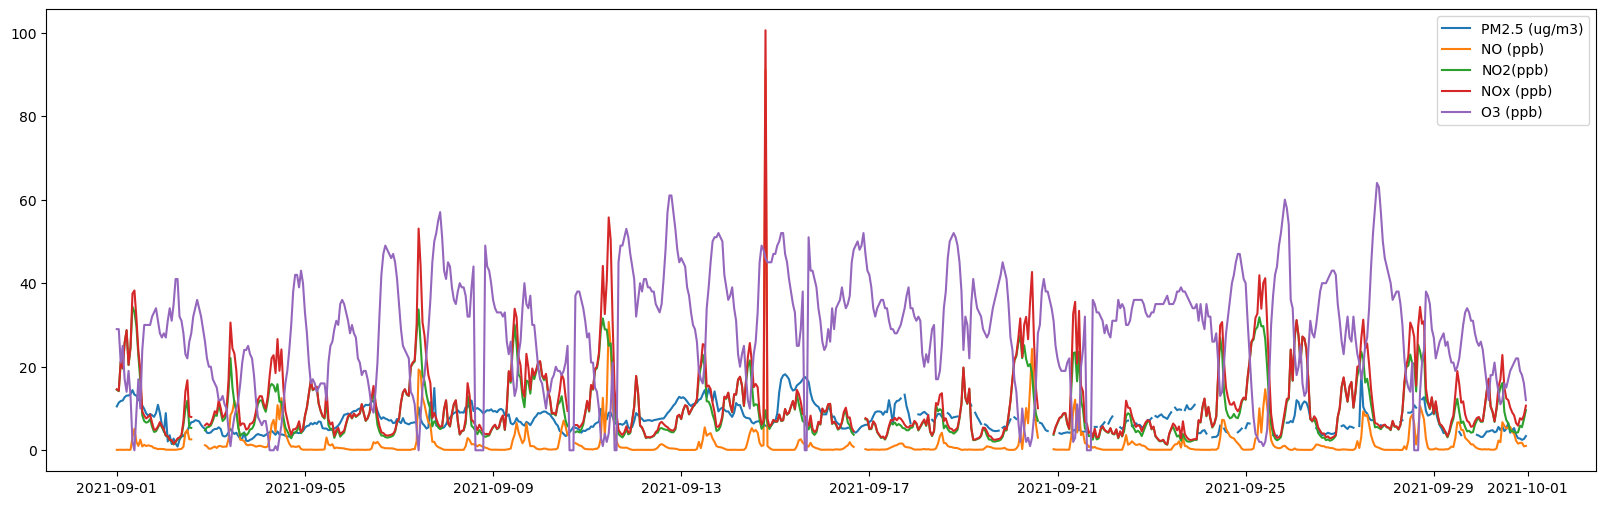

In [36]:
plt.figure(figsize=(20,6))
plt.plot(DEC_sept['PM25FEM (ug/m3)'], label='PM2.5 (ug/m3)')
plt.plot(DEC_sept['NO (ppb)'], label='NO (ppb)')
plt.plot(DEC_sept['NO2 (ppb)'], label='NO2(ppb)')
plt.plot(DEC_sept['NOx (ppb)'], label='NOx (ppb)')
plt.plot(DEC_sept['O3 (ppb)'], label='O3 (ppb)')
#plt.plot(DEC_sept['TEMP (Deg F)'], label='Temp (degF)')
plt.legend()

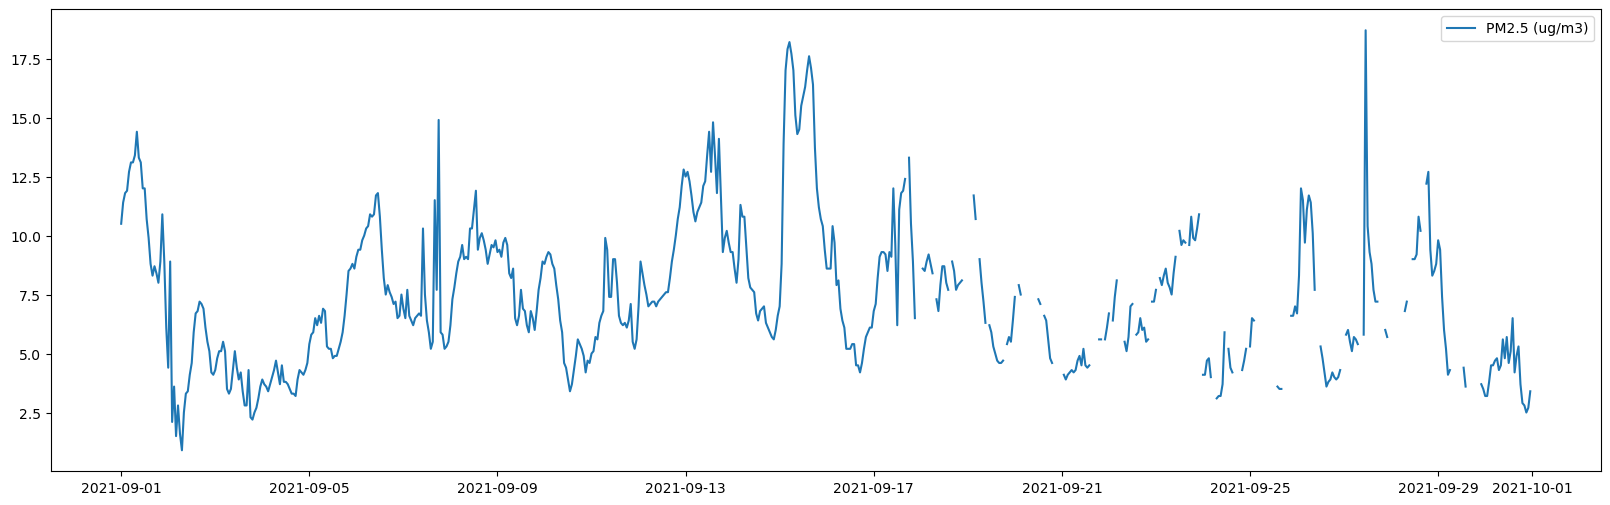

In [37]:
plt.figure(figsize=(20,6))
plt.plot(DEC_sept['PM25FEM (ug/m3)'], label='PM2.5 (ug/m3)')
plt.legend()

missing data for pm are skewed towards the end of the month

#### .. calculate what percentage of data for each pollutant contains a NaN value...

In [38]:
data = DEC_sept.columns
data = data.drop(['date','TEMP (Deg F)', 'SO2T (ppb)', 'O3.1 (ppm)'])
for col in data:
    print(col, ' percent NaN = ', ((DEC_sept[col].isna().sum()/len(DEC_sept))*100).round(2),'%')

O3 (ppb)  percent NaN =  0.0 %
Trace CO (ppb)  percent NaN =  2.22 %
NO (ppb)  percent NaN =  2.92 %
NO2 (ppb)  percent NaN =  2.92 %
NOx (ppb)  percent NaN =  2.92 %
PM25FEM (ug/m3)  percent NaN =  11.94 %


#### .. remove NaN from DEC and reindex to match proto2

In [39]:
DEC_sept = DEC_sept.dropna(axis=0)
proto2_sept_match2DEC = proto2_sept.loc[proto2_sept.index.isin(DEC_sept.index)]
proto2_sept_match2DEC;

#### .. check PM25 data to ensure timezone correction is working 

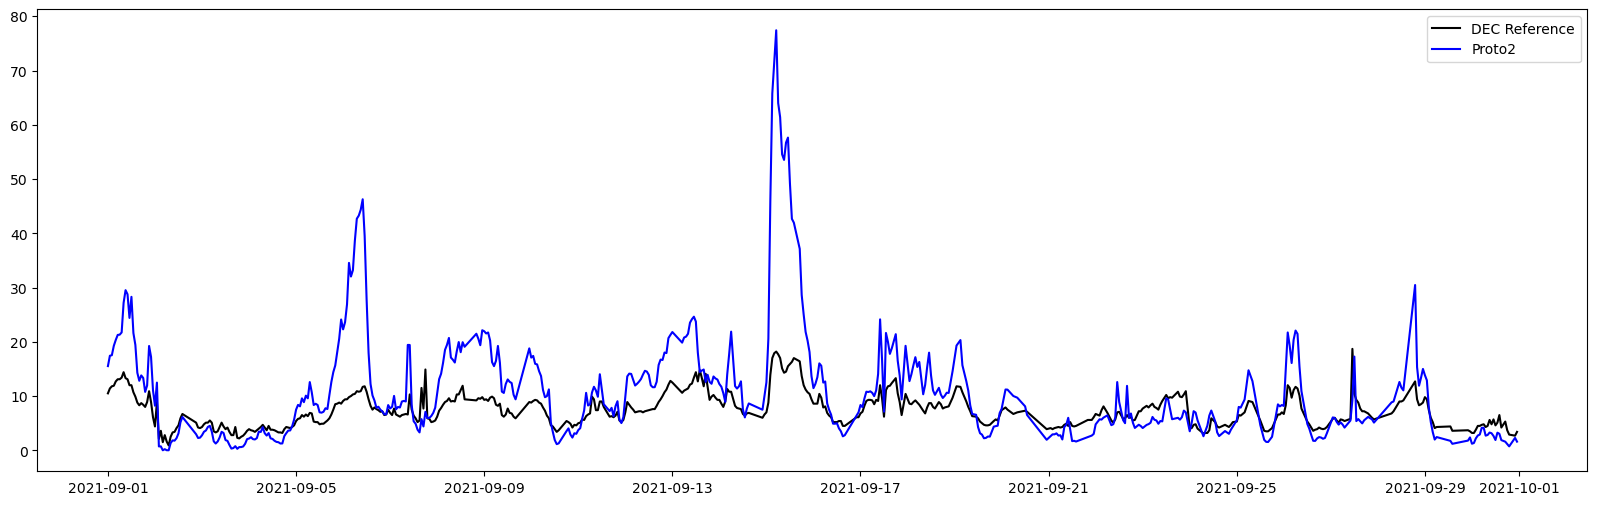

In [40]:
plt.figure(figsize=(20,6))
plt.plot(DEC_sept['PM25FEM (ug/m3)'], label='DEC Reference', color='black')
plt.plot(proto2_sept_match2DEC['pm25_std_ugm3'], label='Proto2', color='blue')
plt.legend()

### data are prepped! 

## EXP. 0 - Training=Testing 

### in this analysis, the testing and training periods both utilize the entire month of September

Working on... CO
Plotting for  CO ...
Saving figure as... CO_September_training-equal-testing_analysis


Working on... O3
Plotting for  O3 ...
Saving figure as... O3_September_training-equal-testing_analysis


Working on... NO
Plotting for  NO ...
Saving figure as... NO_September_training-equal-testing_analysis


Working on... NO2
Plotting for  NO2 ...
Saving figure as... NO2_September_training-equal-testing_analysis


Working on... pm25
Plotting for  pm25 ...
Saving figure as... pm25_September_training-equal-testing_analysis




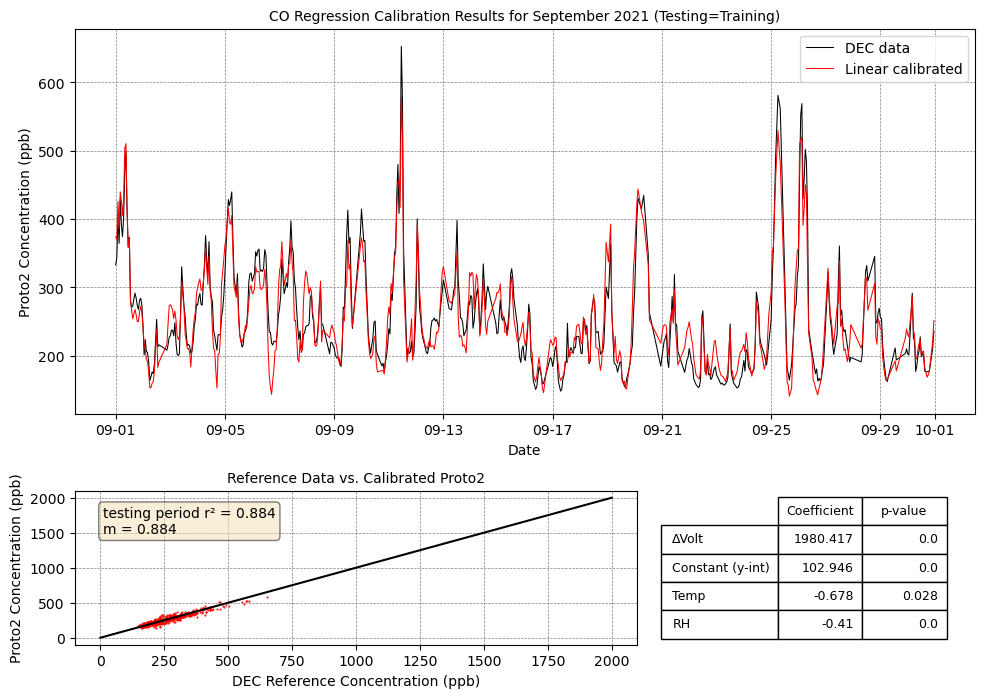

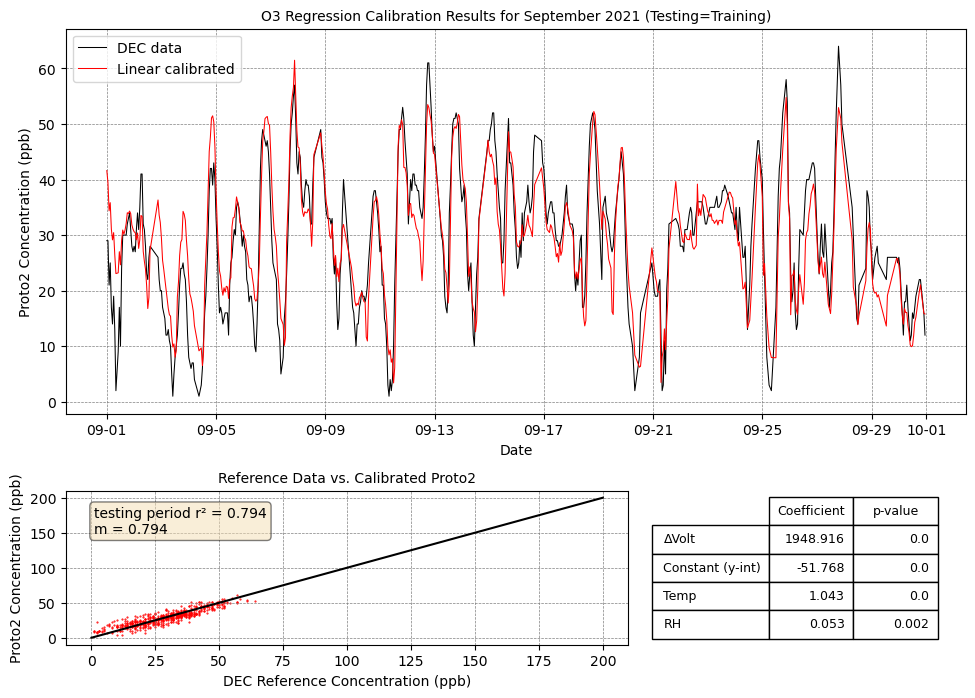

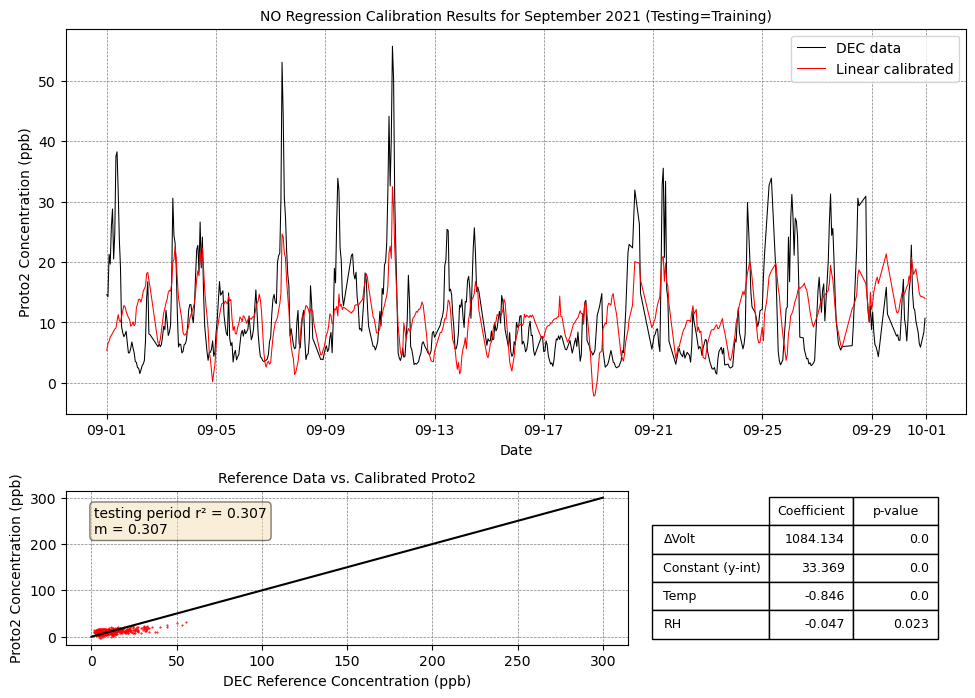

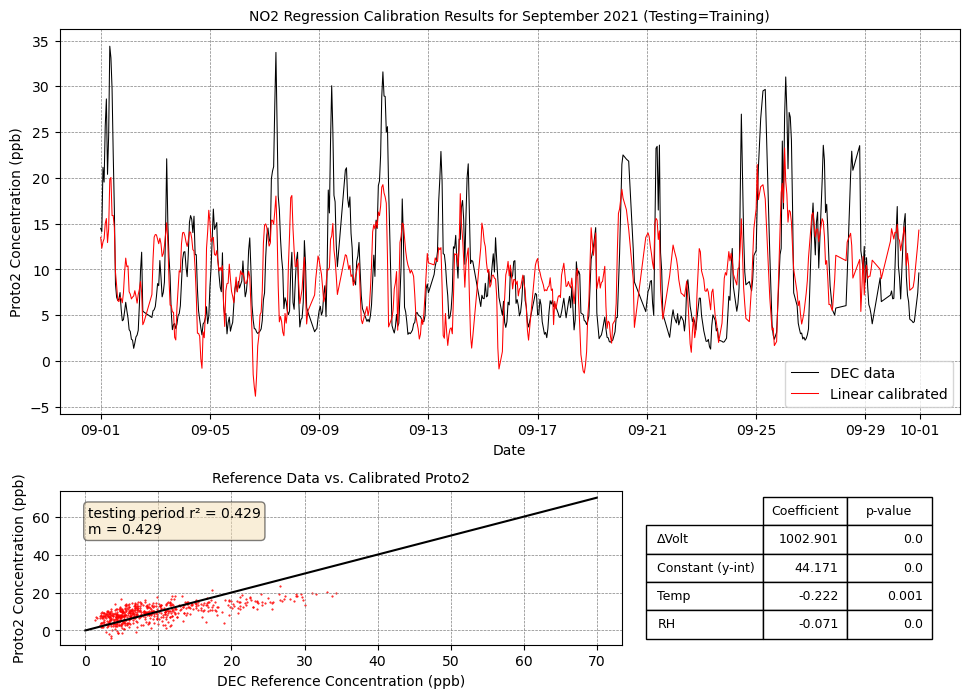

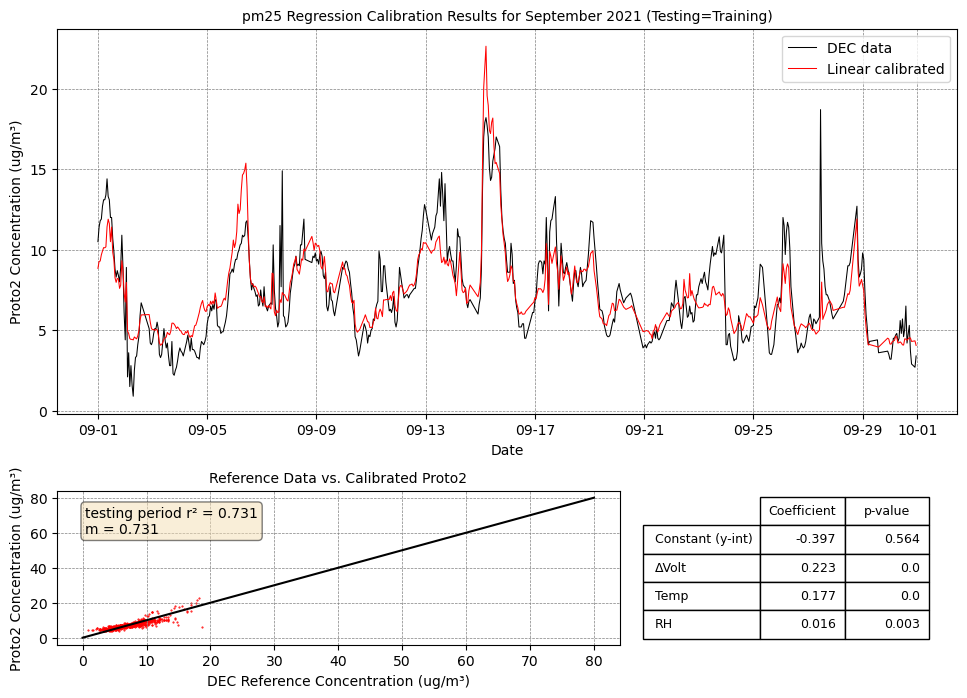

In [42]:
for var_id in [42101, 44201, 42601, 42602, 88101]:
#for var_id in [42101]:
    #get the concentration field that matches the corresponding var_id from observations and convert the time (here it's just a 5 hour conversion)
    if var_id==44201:
        epa_concentration_field=DEC_sept[epa_table[var_id]].rename('value')
    else:
        epa_concentration_field=DEC_sept[epa_table[var_id]].rename('value')
    #combine the observations and proto2 data into one dataset
    combined_df=pd.concat([epa_concentration_field,proto2_sept_match2DEC],axis=1).dropna()
    #include some checks to see if the field is O3 or pm2.5
    #O3 needs to subtract NO2 because the sensor only records O3NO2
    #pm2.5 has a weird naming convention so this statement catches it and renames it to be consistent
    #basically we're just calculating the voltage difference here
    if var_id==44201:
        combined_df['O3_voltdiff']=(combined_df['O3NO2_V']-combined_df['NO2_V']).sub((combined_df['O3NO2_aux_V']-combined_df['NO2_aux_V']),axis=0)
        gname='O3'
        unit = '_ppb'
        pltunit = 'ppb'
    elif var_id in [88101]:
        gname='pm25'
        combined_df[gname+'_voltdiff']=combined_df[gname+'_std_ugm3'].copy()
        unit='_env_ugm3'
        pltunit = 'ug/m³'
    else:
        fname=proto2_table[str(var_id)]
        gname_loc=fname.find('ppb')-1
        gname=fname[:gname_loc]
        combined_df[gname+'_voltdiff']=combined_df[gname+'_V'].sub(combined_df[gname+'_aux_V'],axis=0)
        unit = '_ppb'
        pltunit = 'ppb'
    #perform some additional last minute qc on the data
    #this just tosses out times where the obs data is weird (i.e. is nan, ==0, ==-999, >10*mean)
    combined_df_filtered=combined_df.loc[(~np.isnan(combined_df['value'])) & (combined_df['value']>0) 
                                         & (combined_df['value']!=0) & (combined_df['value']!=-999) 
                                         & (abs(combined_df['value'])<(abs(combined_df['value']).mean()*10))]
    
    # delineate training and test periods 
    combined_df_filtered_training=combined_df_filtered
    combined_df_filtered_testing=combined_df_filtered
                      
    ## training fields using proto2_QC.csv 
    training_reference_concentrations = combined_df_filtered_training['value']
    training_data = [combined_df_filtered_training['temp_sht31_degC'], 
                     combined_df_filtered_training['rh_sht31_percent'], # RH
                     combined_df_filtered_training[gname+'_voltdiff']]
        
    training_data_input = pd.DataFrame(training_data, index=['Temp','RH','ΔVolt']).transpose()
       
    # testing fields using proto2_QC.csv 
    testing_reference_concentrations = combined_df_filtered_testing['value']
    testing_data = [combined_df_filtered_testing['temp_sht31_degC'], # T
                    combined_df_filtered_testing['rh_sht31_percent'], # RH
                    combined_df_filtered_testing[gname+'_voltdiff']]
                                 
                                 
    testing_data_input = pd.DataFrame(testing_data, index=['Temp','RH','ΔVolt']).transpose()
    
    print('Working on...', gname)
    coefficients = generate_coefficients(training_data_input,training_reference_concentrations,'linear')    
    calibrated_data = calibrate(coefficients['coef_dict'], testing_data_input)
    
    training_period_month = str(pd.DatetimeIndex(combined_df_filtered_training.index).month_name()[1])
    testing_period = testing_reference_concentrations.index
       
    ''' stats '''
    m = np.polyfit(testing_reference_concentrations,calibrated_data,1)
    n=len(testing_reference_concentrations)
    r2_testing=(((n*(calibrated_data*testing_reference_concentrations).sum())-(calibrated_data.sum()*testing_reference_concentrations.sum()))\
        /np.sqrt((n*(testing_reference_concentrations**2).sum()-(testing_reference_concentrations).sum()**2)*\
                 (n*(calibrated_data**2).sum()-calibrated_data.sum()**2)))**2
    
    ''' PLOT TIME :) '''
    print('Plotting for ',gname,'...')
    
    fig = plt.subplots(figsize=(10,8))
    ''' DEC vs. Calibrated time series plot (top) '''
    time_series = plt.subplot2grid((3, 3), (0, 0), rowspan=2, colspan=3)
    time_series.set_title('time_series')
    time_series.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
    time_series.plot(testing_period,testing_reference_concentrations,label='DEC data', color='black',linewidth=0.75)
    time_series.plot(testing_period,calibrated_data,label='Linear calibrated', color='red',linewidth=0.75)
    #time_series.plot(testing_period,precalibrated_obs,label='pre-calibrated obs', color='blue',linewidth=0.45)
    time_series.legend()  
    time_series.set_title(gname+' Regression Calibration Results for '+training_period_month+' 2021 (Testing=Training)', fontsize=10)
    time_series.set_xlabel('Date')
    time_series.set_ylabel('Proto2 Concentration ' +'('+pltunit+')') 
    time_series.xaxis.set_major_formatter(DateFormatter('%m-%d'))
    
    ''' DEC vs. Calibrated trend  plot (bottom left) '''
    data_series = plt.subplot2grid((3, 3), (2, 0), colspan=2)
    data_series.set_title('data_series')
    data_series.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
    # 1:1 line
    if var_id==42101: # CO
        xmax = 2000
    if var_id==44201: # O3
        xmax = 200
    if var_id==42601: # NO
        xmax = 300
    if var_id==42602: # N02
        xmax = 70
    if var_id==88101: # pm25
        xmax = 80 
    ymax=xmax
    point1 = [0,0]
    point2 = [xmax,ymax]
    x_values = [point1[0], point2[0]]
    y_values = [point1[1], point2[1]]
    data_series.plot(x_values, y_values, color='black', label='1:1 Line')
    # plotting data... 
    data_series.scatter(testing_reference_concentrations,calibrated_data,color='red',s=0.25)
    data_series.set_xlabel('DEC Reference Concentration '+'('+pltunit+')')
    data_series.set_ylabel('Proto2 Concentration ' +'('+pltunit+')')
    data_series.set_title('Reference Data vs. Calibrated Proto2', fontsize=10)
    data_series.text(0.05, 0.90, 'testing period r² = '+str(r2_testing.round(3))+'\nm = '+str(m[0].round(3)), 
                     transform=data_series.transAxes, fontsize=10,verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    ''' Regression Coefficient Table (bottom right) '''
    table_data = pd.DataFrame()
    table_data = table_data.append([coefficients['coef_dict'], coefficients['pvalue_dict']],ignore_index=True).transpose().rename(columns = {0:'Coefficient', 1:'p-value'}, 
                                                                                                                                  index={'Y-intercept (constant term)':'Constant (y-int)'}).round(3)
    table_data = table_data.reindex((table_data.abs().sort_values(by=['Coefficient'], ascending=False)).index) # sorts table by highest abs value of coefficient 
    table = plt.subplot2grid((3, 3), (2, 2))
    #hide the axes
    table.patch.set_visible(False)
    table.axis('off')
    table.axis('tight')
    regression_table = table.table(cellText=table_data.values, rowLabels=table_data.index, colLabels = table_data.columns,loc='center')
    regression_table.scale(0.75,2)
    regression_table.set_fontsize(15)
    plt.subplots_adjust(left=0, wspace=0.50, hspace=0.50)
    figname = str(gname+'_'+training_period_month+'_training-equal-testing_analysis')
    print('Saving figure as...',figname)
    filepath = '/data/shared/ehojeily/september_analysis/'
    plt.savefig(filepath+figname+'.png',bbox_inches='tight',dpi=300)
    
    '''
    with open(filepath+'readme.txt', 'w') as f:
        f.write('Proto2 calibration analysis plots using generate_coefficients and calibrate function. \n Script used: pvalue_draft2.ipynb')
    '''
    print('\n')


## EXP. 1 - 50/50 Method


### calibration month is split evenly in half into two parts; beginning half is the training period and the latter half is the testing period  


Working on... CO
Plotting for  CO ...
Saving figure as... CO_October_fifty-fifty_analysis


Working on... O3
Plotting for  O3 ...
Saving figure as... O3_October_fifty-fifty_analysis


Working on... NO
Plotting for  NO ...
Saving figure as... NO_October_fifty-fifty_analysis


Working on... NO2
Plotting for  NO2 ...
Saving figure as... NO2_October_fifty-fifty_analysis


Working on... pm25
Plotting for  pm25 ...
Saving figure as... pm25_October_fifty-fifty_analysis


Training period = 2021-10-01 01:00:00+00:00 until 2021-10-16 18:00:00+00:00
Testing period = 2021-10-16 19:00:00+00:00 until 2021-10-31 23:00:00+00:00


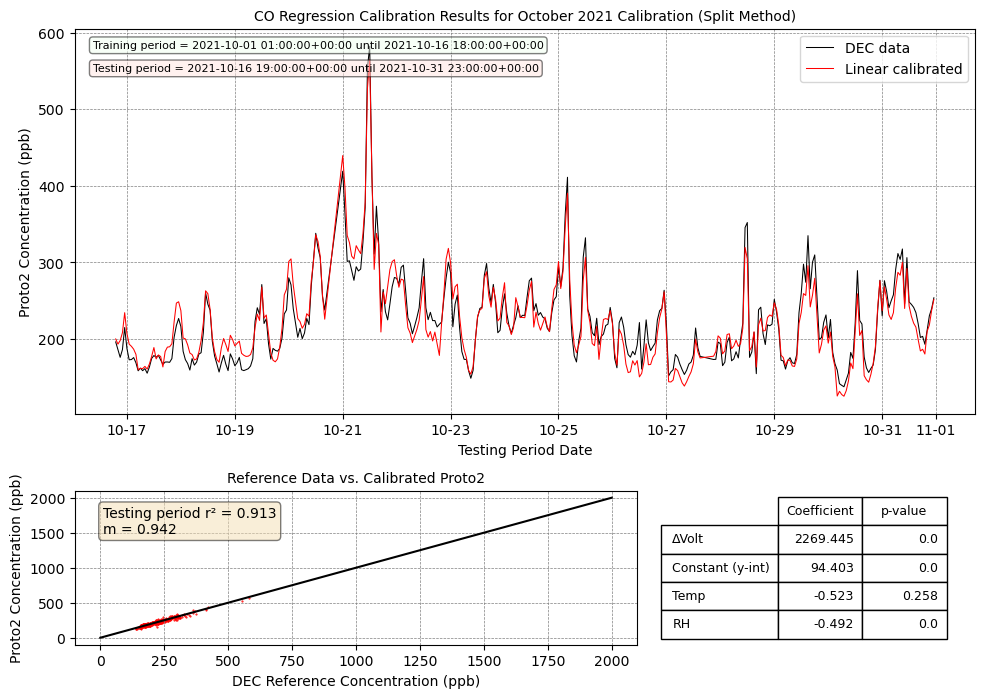

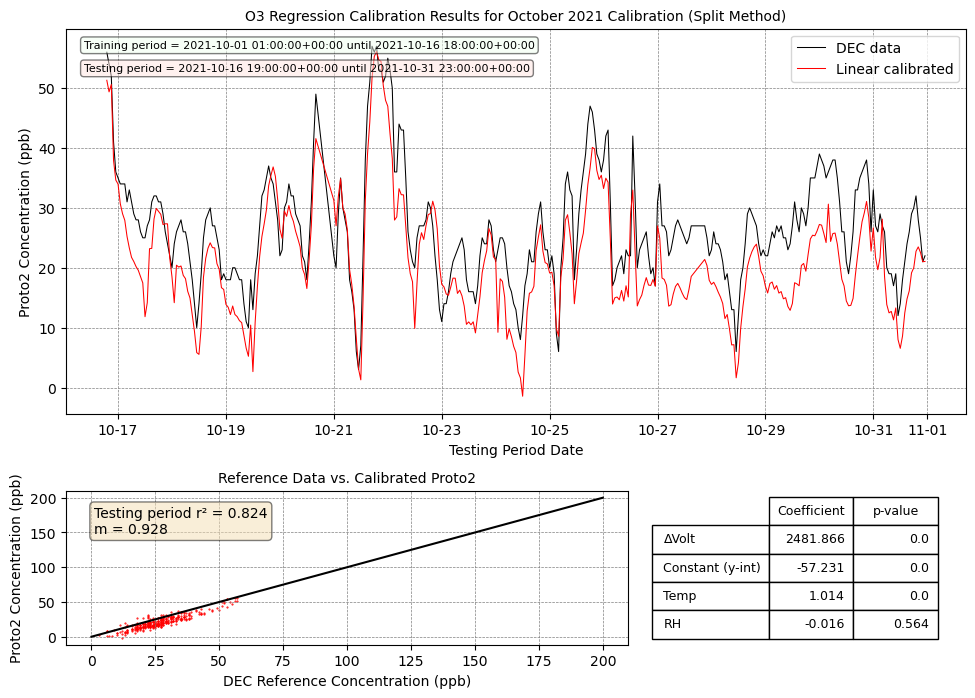

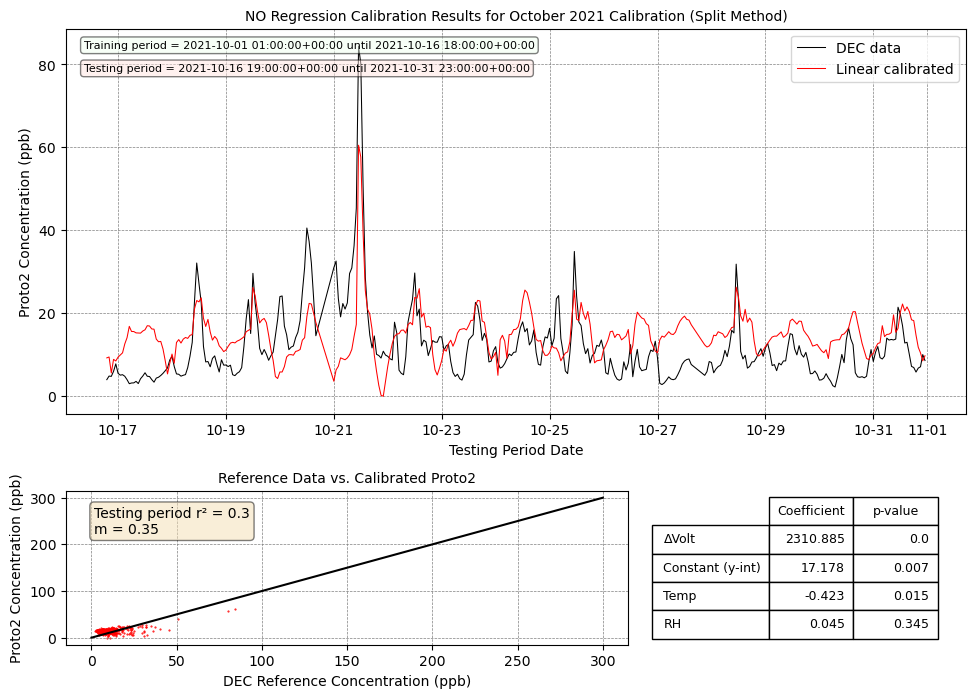

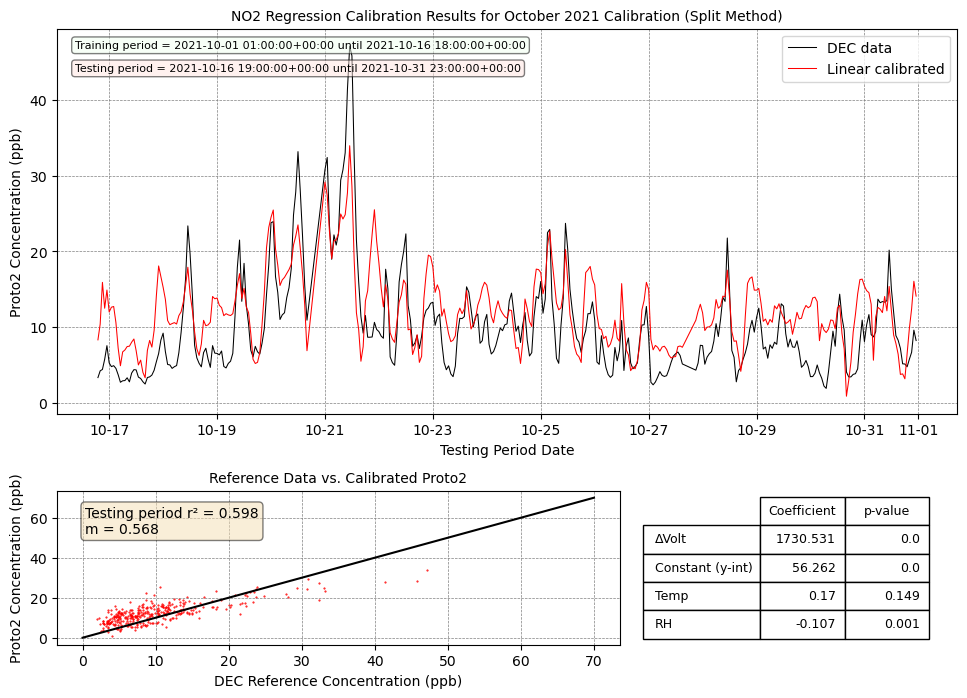

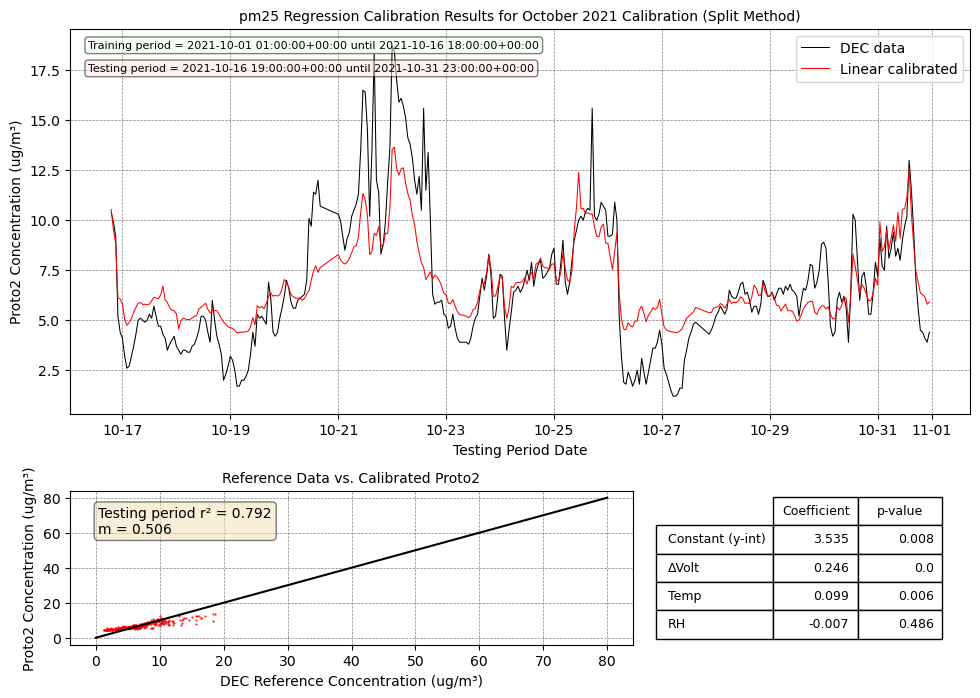

In [17]:
for var_id in [42101, 44201, 42601, 42602, 88101]:
#for var_id in [42101]:
    #get the concentration field that matches the corresponding var_id from observations and convert the time (here it's just a 5 hour conversion)
    if var_id==44201:
        epa_concentration_field=DEC_sept[epa_table[var_id]].rename('value')
    else:
        epa_concentration_field=DEC_sept[epa_table[var_id]].rename('value')
    #combine the observations and proto2 data into one dataset
    combined_df=pd.concat([epa_concentration_field,proto2_sept_match2DEC],axis=1).dropna()
    #include some checks to see if the field is O3 or pm2.5
    #O3 needs to subtract NO2 because the sensor only records O3NO2
    #pm2.5 has a weird naming convention so this statement catches it and renames it to be consistent
    #basically we're just calculating the voltage difference here
    if var_id==44201:
        combined_df['O3_voltdiff']=(combined_df['O3NO2_V']-combined_df['NO2_V']).sub((combined_df['O3NO2_aux_V']-combined_df['NO2_aux_V']),axis=0)
        gname='O3'
        unit = '_ppb'
        pltunit = 'ppb'
    elif var_id in [88101]:
        gname='pm25'
        combined_df[gname+'_voltdiff']=combined_df[gname+'_std_ugm3'].copy()
        unit='_env_ugm3'
        pltunit = 'ug/m³'
    else:
        fname=proto2_table[str(var_id)]
        gname_loc=fname.find('ppb')-1
        gname=fname[:gname_loc]
        combined_df[gname+'_voltdiff']=combined_df[gname+'_V'].sub(combined_df[gname+'_aux_V'],axis=0)
        unit = '_ppb'
        pltunit = 'ppb'
    #perform some additional last minute qc on the data
    #this just tosses out times where the obs data is weird (i.e. is nan, ==0, ==-999, >10*mean)
    combined_df_filtered=combined_df.loc[(~np.isnan(combined_df['value'])) & (combined_df['value']>0) 
                                         & (combined_df['value']!=0) & (combined_df['value']!=-999) 
                                         & (abs(combined_df['value'])<(abs(combined_df['value']).mean()*10))]
    
    # delineate training and test periods
    nrows = len(combined_df_filtered)
    combined_df_filtered_training=combined_df_filtered.iloc[:nrows//2,:] # first half
    combined_df_filtered_testing=combined_df_filtered.iloc[nrows//2:,:] # latter half
    training_string = 'Training period = '+str(combined_df_filtered_training.head(1).index[0])+' until '+str(combined_df_filtered_training.tail(1).index[0]) # for plotting 
    testing_string = 'Testing period = '+str(combined_df_filtered_testing.head(1).index[0])+' until '+str(combined_df_filtered_testing.tail(1).index[0]) # for plotting
    
    ## training fields using proto2_QC.csv 
    training_reference_concentrations = combined_df_filtered_training['value']
    training_data = [combined_df_filtered_training['temp_sht31_degC'], 
                     combined_df_filtered_training['rh_sht31_percent'], # RH
                     combined_df_filtered_training[gname+'_voltdiff']]
        
    training_data_input = pd.DataFrame(training_data, index=['Temp','RH','ΔVolt']).transpose()
       
    # testing fields using proto2_QC.csv 
    testing_reference_concentrations = combined_df_filtered_testing['value']
    testing_data = [combined_df_filtered_testing['temp_sht31_degC'], # T
                    combined_df_filtered_testing['rh_sht31_percent'], # RH
                    combined_df_filtered_testing[gname+'_voltdiff']]
                                 
                                 
    testing_data_input = pd.DataFrame(testing_data, index=['Temp','RH','ΔVolt']).transpose()
    
    print('Working on...', gname)
    coefficients = generate_coefficients(training_data_input,training_reference_concentrations,'linear')    
    calibrated_data = calibrate(coefficients['coef_dict'], testing_data_input)
    
    training_period_month = str(pd.DatetimeIndex(combined_df_filtered_training.index).month_name()[1])
    testing_period = testing_reference_concentrations.index
       
    ''' stats '''
    m = np.polyfit(testing_reference_concentrations,calibrated_data,1)
    n=len(testing_reference_concentrations)
    r2_testing=(((n*(calibrated_data*testing_reference_concentrations).sum())-(calibrated_data.sum()*testing_reference_concentrations.sum()))\
        /np.sqrt((n*(testing_reference_concentrations**2).sum()-(testing_reference_concentrations).sum()**2)*\
                 (n*(calibrated_data**2).sum()-calibrated_data.sum()**2)))**2
    
    ''' PLOT TIME :) '''
    print('Plotting for ',gname,'...')
    
    fig = plt.subplots(figsize=(10,8))
    ''' DEC vs. Calibrated time series plot (top) '''
    time_series = plt.subplot2grid((3, 3), (0, 0), rowspan=2, colspan=3)
    time_series.set_title('time_series')
    time_series.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
    time_series.plot(testing_period,testing_reference_concentrations,label='DEC data', color='black',linewidth=0.75)
    time_series.plot(testing_period,calibrated_data,label='Linear calibrated', color='red',linewidth=0.75)
    #time_series.plot(testing_period,precalibrated_obs,label='pre-calibrated obs', color='blue',linewidth=0.45)
    time_series.legend()  
    time_series.set_title(gname+' Regression Calibration Results for '+training_period_month+' 2021 Calibration (Split Method)', fontsize=10)
    time_series.set_xlabel('Testing Period Date')
    time_series.set_ylabel('Proto2 Concentration ' +'('+pltunit+')') 
    time_series.xaxis.set_major_formatter(DateFormatter('%m-%d'))
    time_series.text(0.02, 0.97, training_string, 
                     transform=time_series.transAxes, fontsize=8,verticalalignment='top', bbox=dict(boxstyle='round', facecolor='honeydew', alpha=0.5))
    time_series.text(0.02, 0.91, testing_string, 
                     transform=time_series.transAxes, fontsize=8,verticalalignment='top', bbox=dict(boxstyle='round', facecolor='mistyrose', alpha=0.5))
    
    ''' DEC vs. Calibrated trend  plot (bottom left) '''
    data_series = plt.subplot2grid((3, 3), (2, 0), colspan=2)
    data_series.set_title('data_series')
    data_series.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
    # 1:1 line
    if var_id==42101: # CO
        xmax = 2000
    if var_id==44201: # O3
        xmax = 200
    if var_id==42601: # NO
        xmax = 300
    if var_id==42602: # N02
        xmax = 70
    if var_id==88101: # pm25
        xmax = 80 
    ymax=xmax
    point1 = [0,0]
    point2 = [xmax,ymax]
    x_values = [point1[0], point2[0]]
    y_values = [point1[1], point2[1]]
    data_series.plot(x_values, y_values, color='black', label='1:1 Line')
    # plotting data... 
    data_series.scatter(testing_reference_concentrations,calibrated_data,color='red',s=0.25)
    data_series.set_xlabel('DEC Reference Concentration '+'('+pltunit+')')
    data_series.set_ylabel('Proto2 Concentration ' +'('+pltunit+')')
    data_series.set_title('Reference Data vs. Calibrated Proto2', fontsize=10)
    data_series.text(0.05, 0.90, 'Testing period r² = '+str(r2_testing.round(3))+'\nm = '+str(m[0].round(3)), 
                     transform=data_series.transAxes, fontsize=10,verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    
    ''' Regression Coefficient Table (bottom right) '''
    table_data = pd.DataFrame()
    table_data = table_data.append([coefficients['coef_dict'], coefficients['pvalue_dict']],ignore_index=True).transpose().rename(columns = {0:'Coefficient', 1:'p-value'}, 
                                                                                                                                  index={'Y-intercept (constant term)':'Constant (y-int)'}).round(3)
    table_data = table_data.reindex((table_data.abs().sort_values(by=['Coefficient'], ascending=False)).index) # sorts table by highest abs value of coefficient 
    table = plt.subplot2grid((3, 3), (2, 2))
    #hide the axes
    table.patch.set_visible(False)
    table.axis('off')
    table.axis('tight')
    regression_table = table.table(cellText=table_data.values, rowLabels=table_data.index, colLabels = table_data.columns,loc='center')
    regression_table.scale(0.75,2)
    regression_table.set_fontsize(15)
    plt.subplots_adjust(left=0, wspace=0.50, hspace=0.50)
    figname = str(gname+'_'+training_period_month+'_fifty-fifty_analysis')
    print('Saving figure as...',figname)
    filepath = '/data/shared/ehojeily/september_analysis/'
    plt.savefig(filepath+figname+'.png',bbox_inches='tight',dpi=300)
    
    '''
    with open(filepath+'readme.txt', 'w') as f:
        f.write('Proto2 calibration analysis plots using generate_coefficients and calibrate function. \n Script used: pvalue_draft2.ipynb')
    '''
    print('\n')
print(training_string)
print(testing_string)

## EXP. 2 - Fixed Random Sampling Method

### training and testing period dates are randomly determined but are not overlapping (meaning a date cannot be within the training and testing period)

#### .. delineate testing and training periods randomly ONCE and then write to a text file and store it for future use 

In [18]:
dates = pd.concat([epa_concentration_field,proto2_sept_match2DEC],axis=1) # creating dataframe of just september dates
training_dates = dates.sample(frac=0.5) # randomly select half of the data 
testing_dates = (dates.copy()).loc[~dates.copy().index.isin(training_dates.index)] # selecting data not included in previous random selection aka remaining dates 

#### .. plot to see distribution of random date selection

Text(0.5, 1.0, 'Randomly selected training and testing period for September (DEC Reference data plotted for pm25)')

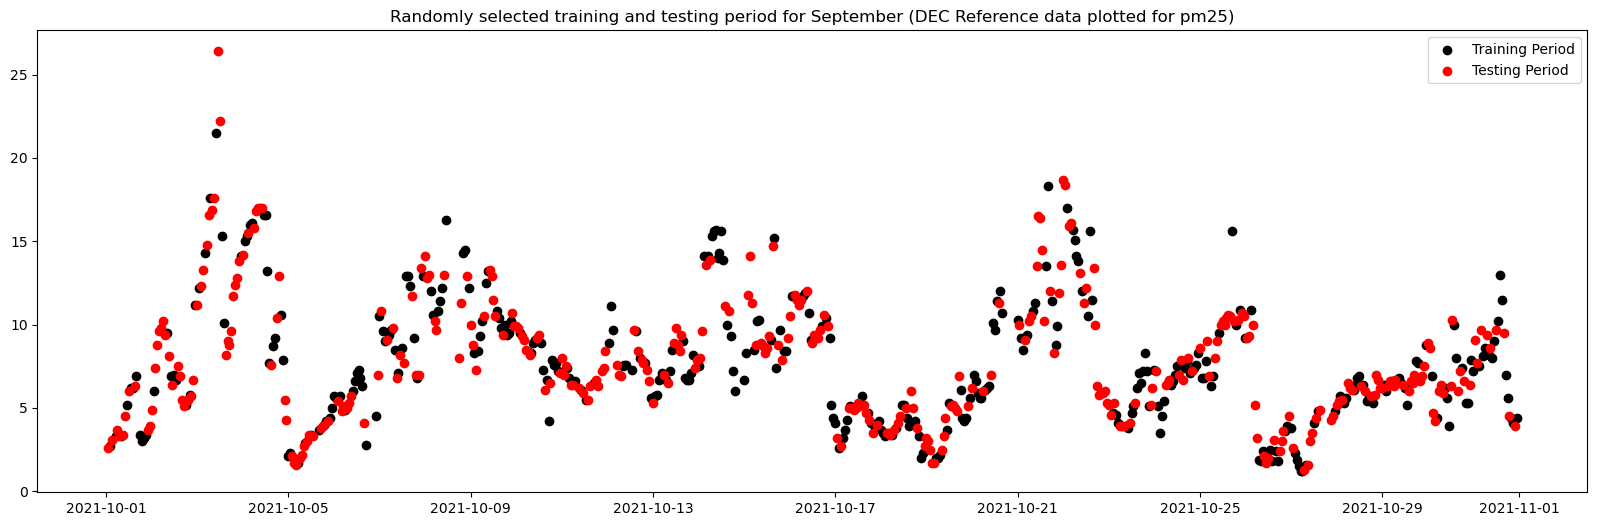

In [19]:
plt.figure(figsize=(20,6))
plt.scatter(training_dates.index,training_dates['value'], label='Training Period', color='black')
plt.scatter(testing_dates.index,testing_dates['value'], label='Testing Period', color='red')
plt.legend()
plt.title('Randomly selected training and testing period for September (DEC Reference data plotted for pm25)')

#### .. output dates to txt files

In [60]:
os.remove("training_dates_sept.txt") # remove old text files to avoid writing over existing text 
os.remove("testing_dates_sept.txt") # remove old text files to avoid writing over existing text 
os.remove("training_dates_oct.txt") # remove old text files to avoid writing over existing text 
os.remove("testing_dates_oct.txt") # remove old text files to avoid writing over existing text 

FileNotFoundError: [Errno 2] No such file or directory: 'training_dates_sept.txt'

In [20]:
#pd.DataFrame(training_dates.index).to_csv(r'training_dates_sept.txt', header=None, index=None, sep=' ', mode='a')
#pd.DataFrame(testing_dates.index).to_csv(r'testing_dates_sept.txt', header=None, index=None, sep=' ', mode='a')
pd.DataFrame(training_dates.index).to_csv(r'training_dates_oct.txt', header=None, index=None, sep=' ', mode='a')
pd.DataFrame(testing_dates.index).to_csv(r'testing_dates_oct.txt', header=None, index=None, sep=' ', mode='a')

### apply calibration

Working on... CO
Plotting for  CO ...
Saving figure as... CO_October_fixedrandsampling_analysis


Working on... O3
Plotting for  O3 ...
Saving figure as... O3_October_fixedrandsampling_analysis


Working on... NO
Plotting for  NO ...
Saving figure as... NO_October_fixedrandsampling_analysis


Working on... NO2
Plotting for  NO2 ...
Saving figure as... NO2_October_fixedrandsampling_analysis


Working on... pm25
Plotting for  pm25 ...
Saving figure as... pm25_October_fixedrandsampling_analysis




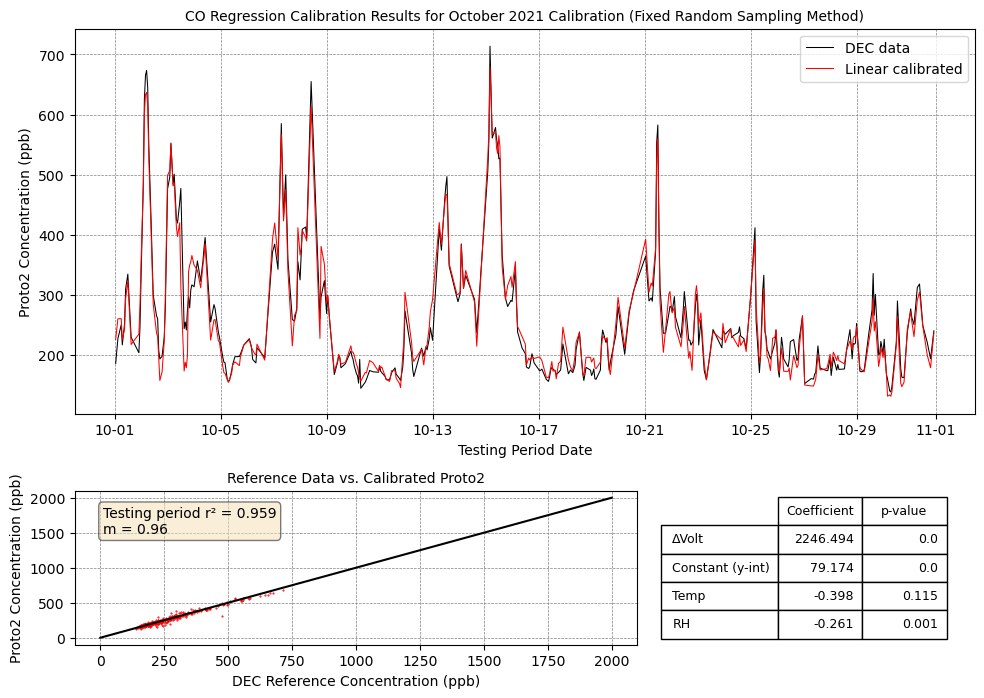

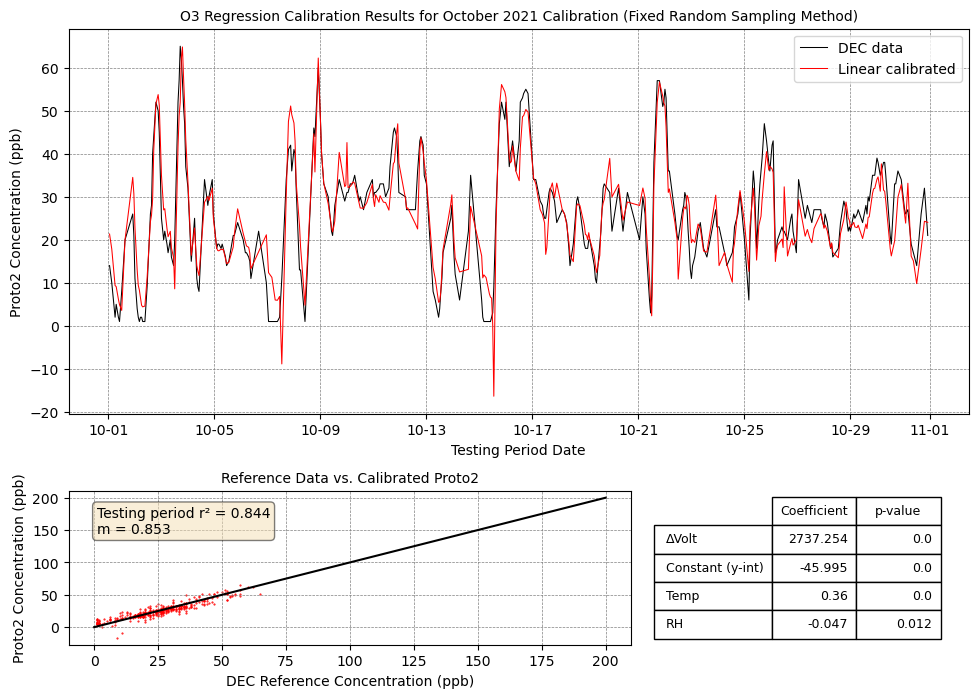

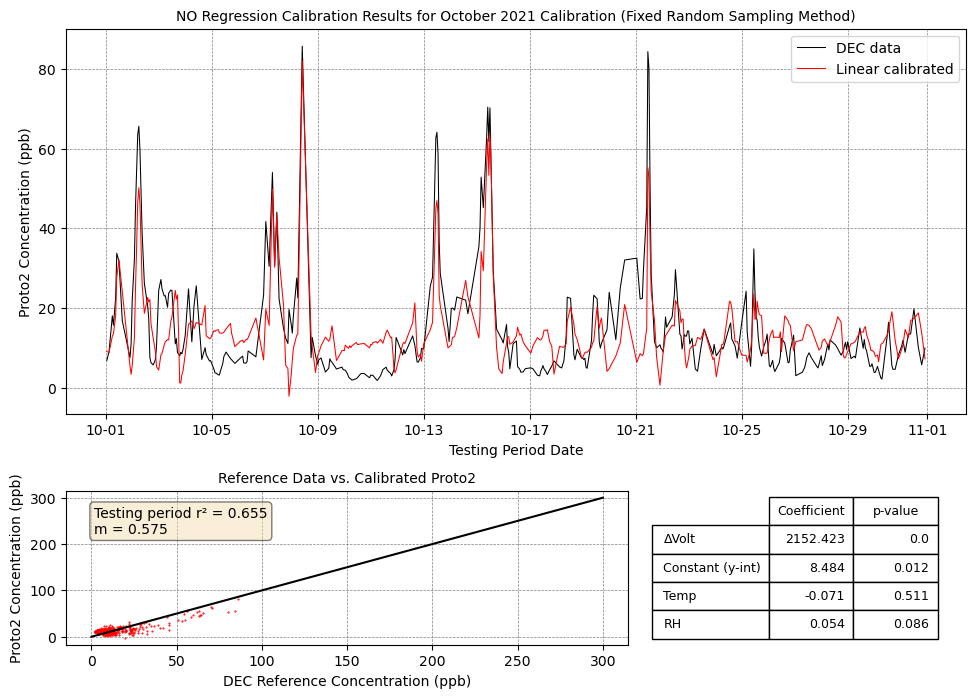

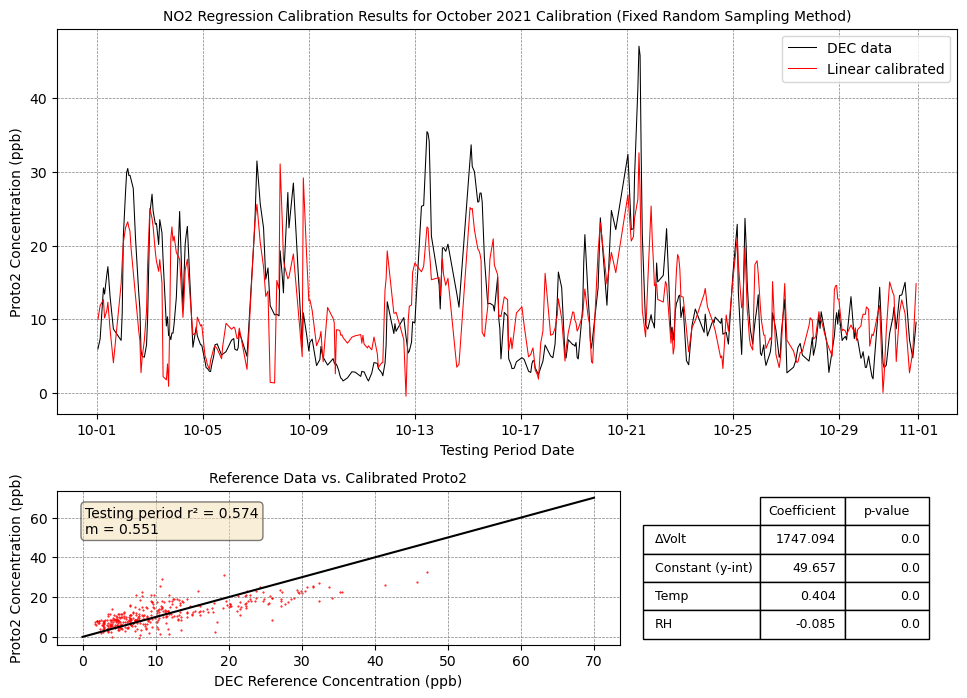

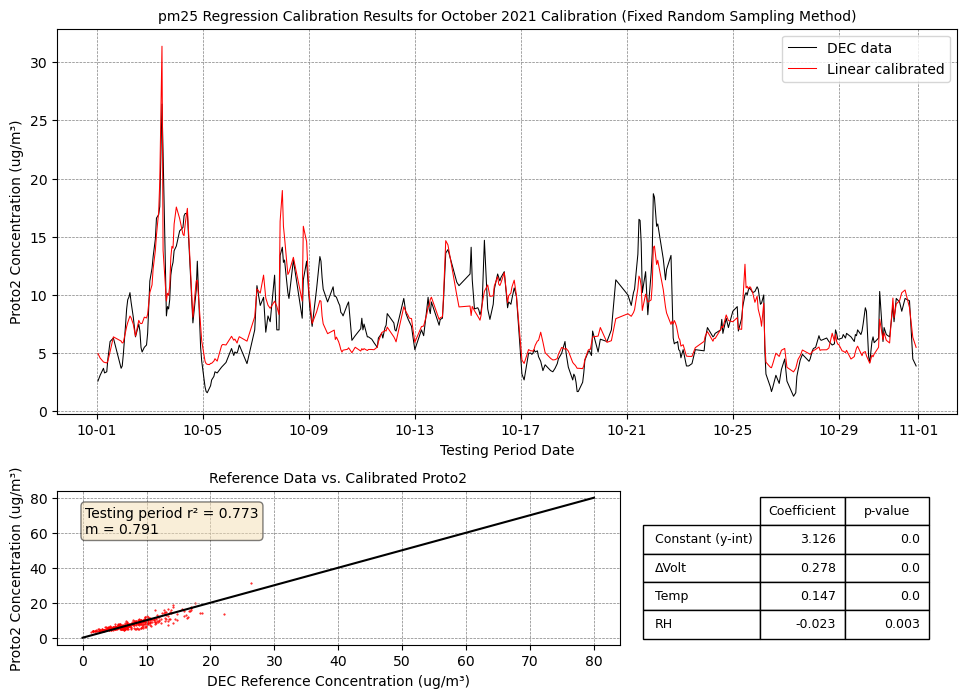

In [21]:
for var_id in [42101, 44201, 42601, 42602, 88101]:
#for var_id in [42101]:
    #get the concentration field that matches the corresponding var_id from observations and convert the time (here it's just a 5 hour conversion)
    epa_concentration_field=DEC_sept[epa_table[var_id]].rename('value')
    #combine the observations and proto2 data into one dataset
    combined_df=pd.concat([epa_concentration_field,proto2_sept_match2DEC],axis=1).dropna()
    #include some checks to see if the field is O3 or pm2.5
    #O3 needs to subtract NO2 because the sensor only records O3NO2
    #pm2.5 has a weird naming convention so this statement catches it and renames it to be consistent
    #basically we're just calculating the voltage difference here
    if var_id==44201:
        combined_df['O3_voltdiff']=(combined_df['O3NO2_V']-combined_df['NO2_V']).sub((combined_df['O3NO2_aux_V']-combined_df['NO2_aux_V']),axis=0)
        gname='O3'
        unit = '_ppb'
        pltunit = 'ppb'
    elif var_id in [88101]:
        gname='pm25'
        combined_df[gname+'_voltdiff']=combined_df[gname+'_std_ugm3'].copy()
        unit='_env_ugm3'
        pltunit = 'ug/m³'
    else:
        fname=proto2_table[str(var_id)]
        gname_loc=fname.find('ppb')-1
        gname=fname[:gname_loc]
        combined_df[gname+'_voltdiff']=combined_df[gname+'_V'].sub(combined_df[gname+'_aux_V'],axis=0)
        unit = '_ppb'
        pltunit = 'ppb'
    #perform some additional last minute qc on the data
    #this just tosses out times where the obs data is weird (i.e. is nan, ==0, ==-999, >10*mean)
    '''
    combined_df_filtered=combined_df.loc[(~np.isnan(combined_df['value'])) & (combined_df['value']>0) 
                                         & (combined_df['value']!=0) & (combined_df['value']!=-999) 
                                         & (abs(combined_df['value'])<(abs(combined_df['value']).mean()*10))]
    '''
    
    # delineate training and test periods
    combined_df_filtered_training=combined_df.loc[training_dates.index] 
    combined_df_filtered_testing=combined_df.loc[testing_dates.index]
    
    ## training fields using proto2_QC.csv 
    training_reference_concentrations = combined_df_filtered_training['value']
    training_data = [combined_df_filtered_training['temp_sht31_degC'], 
                     combined_df_filtered_training['rh_sht31_percent'], # RH
                     combined_df_filtered_training[gname+'_voltdiff']]
        
    training_data_input = pd.DataFrame(training_data, index=['Temp','RH','ΔVolt']).transpose()
       
    # testing fields using proto2_QC.csv 
    testing_reference_concentrations = combined_df_filtered_testing['value']
    testing_data = [combined_df_filtered_testing['temp_sht31_degC'], # T
                    combined_df_filtered_testing['rh_sht31_percent'], # RH
                    combined_df_filtered_testing[gname+'_voltdiff']]
                                 
                                 
    testing_data_input = pd.DataFrame(testing_data, index=['Temp','RH','ΔVolt']).transpose()
    
    print('Working on...', gname)
    coefficients = generate_coefficients(training_data_input,training_reference_concentrations,'linear')    
    calibrated_data = calibrate(coefficients['coef_dict'], testing_data_input)
    
    training_period_month = str(pd.DatetimeIndex(combined_df_filtered_training.index).month_name()[1])
    testing_period = testing_reference_concentrations.index
       
    ''' stats '''
    m = np.polyfit(testing_reference_concentrations,calibrated_data,1)
    n=len(testing_reference_concentrations)
    r2_testing=(((n*(calibrated_data*testing_reference_concentrations).sum())-(calibrated_data.sum()*testing_reference_concentrations.sum()))\
        /np.sqrt((n*(testing_reference_concentrations**2).sum()-(testing_reference_concentrations).sum()**2)*\
                 (n*(calibrated_data**2).sum()-calibrated_data.sum()**2)))**2
    
    ''' PLOT TIME :) '''
    print('Plotting for ',gname,'...')
    
    fig = plt.subplots(figsize=(10,8))
    ''' DEC vs. Calibrated time series plot (top) '''
    time_series = plt.subplot2grid((3, 3), (0, 0), rowspan=2, colspan=3)
    time_series.set_title('time_series')
    time_series.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
    time_series.plot(testing_period,testing_reference_concentrations,label='DEC data', color='black',linewidth=0.75)
    time_series.plot(testing_period,calibrated_data,label='Linear calibrated', color='red',linewidth=0.75)
    time_series.legend()  
    time_series.set_title(gname+' Regression Calibration Results for '+training_period_month+' 2021 Calibration (Fixed Random Sampling Method)', fontsize=10)
    time_series.set_xlabel('Testing Period Date')
    time_series.set_ylabel('Proto2 Concentration ' +'('+pltunit+')') 
    time_series.xaxis.set_major_formatter(DateFormatter('%m-%d'))
    
    ''' DEC vs. Calibrated trend  plot (bottom left) '''
    data_series = plt.subplot2grid((3, 3), (2, 0), colspan=2)
    data_series.set_title('data_series')
    data_series.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
    # 1:1 line
    if var_id==42101: # CO
        xmax = 2000
    if var_id==44201: # O3
        xmax = 200
    if var_id==42601: # NO
        xmax = 300
    if var_id==42602: # N02
        xmax = 70
    if var_id==88101: # pm25
        xmax = 80 
    ymax=xmax
    point1 = [0,0]
    point2 = [xmax,ymax]
    x_values = [point1[0], point2[0]]
    y_values = [point1[1], point2[1]]
    data_series.plot(x_values, y_values, color='black', label='1:1 Line')
    # plotting data... 
    data_series.scatter(testing_reference_concentrations,calibrated_data,color='red',s=0.25)
    data_series.set_xlabel('DEC Reference Concentration '+'('+pltunit+')')
    data_series.set_ylabel('Proto2 Concentration ' +'('+pltunit+')')
    data_series.set_title('Reference Data vs. Calibrated Proto2', fontsize=10)
    data_series.text(0.05, 0.90, 'Testing period r² = '+str(r2_testing.round(3))+'\nm = '+str(m[0].round(3)), 
                     transform=data_series.transAxes, fontsize=10,verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    
    ''' Regression Coefficient Table (bottom right) '''
    table_data = pd.DataFrame()
    table_data = table_data.append([coefficients['coef_dict'], coefficients['pvalue_dict']],ignore_index=True).transpose().rename(columns = {0:'Coefficient', 1:'p-value'}, 
                                                                                                                                  index={'Y-intercept (constant term)':'Constant (y-int)'}).round(3)
    table_data = table_data.reindex((table_data.abs().sort_values(by=['Coefficient'], ascending=False)).index) # sorts table by highest abs value of coefficient 
    table = plt.subplot2grid((3, 3), (2, 2))
    #hide the axes
    table.patch.set_visible(False)
    table.axis('off')
    table.axis('tight')
    regression_table = table.table(cellText=table_data.values, rowLabels=table_data.index, colLabels = table_data.columns,loc='center')
    regression_table.scale(0.75,2)
    regression_table.set_fontsize(15)
    plt.subplots_adjust(left=0, wspace=0.50, hspace=0.50)
    figname = str(gname+'_'+training_period_month+'_fixedrandsampling_analysis')
    print('Saving figure as...',figname)
    filepath = '/data/shared/ehojeily/september_analysis/'
    plt.savefig(filepath+figname+'.png',bbox_inches='tight',dpi=300)
    
    '''
    with open(filepath+'readme.txt', 'w') as f:
        f.write('Proto2 calibration analysis plots using generate_coefficients and calibrate function. \n Script used: pvalue_draft2.ipynb')
    '''
    print('\n')

## EXP. 3 - "Classic" Random Sampling Method

### calibration would be run multiple times and each time the training and testing periods would be randomly sampled, the results would be an average of however many tests are run

Plotting for  CO ...
Saving figure as... CO_September_avgrandsamp_analysis


Plotting for  O3 ...
Saving figure as... O3_September_avgrandsamp_analysis


Plotting for  NO ...
Saving figure as... NO_September_avgrandsamp_analysis


Plotting for  NO2 ...
Saving figure as... NO2_September_avgrandsamp_analysis


Plotting for  pm25 ...
Saving figure as... pm25_September_avgrandsamp_analysis




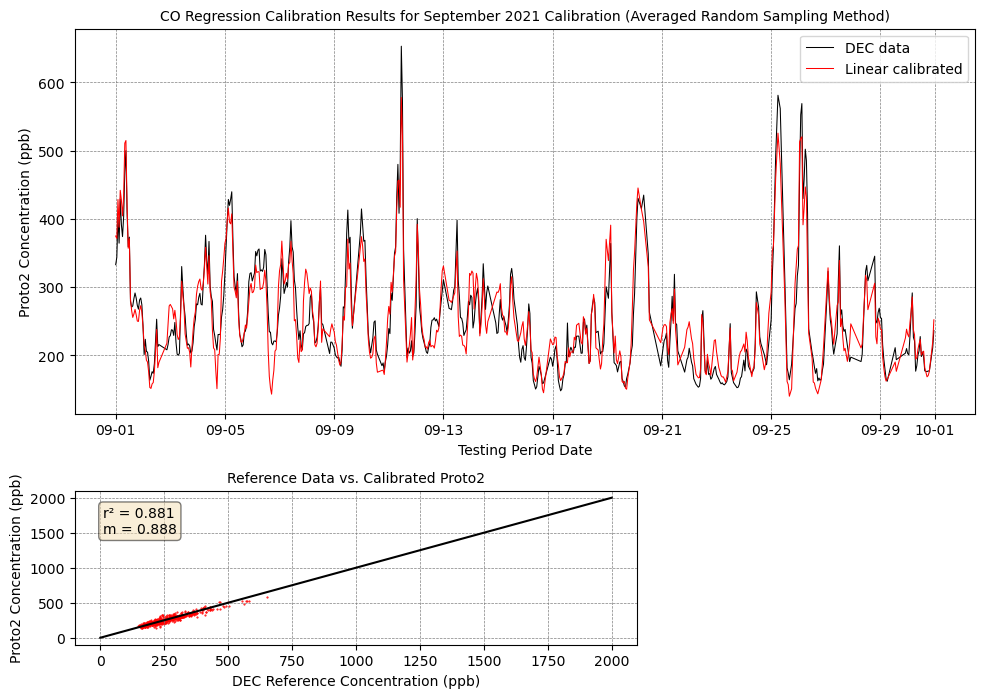

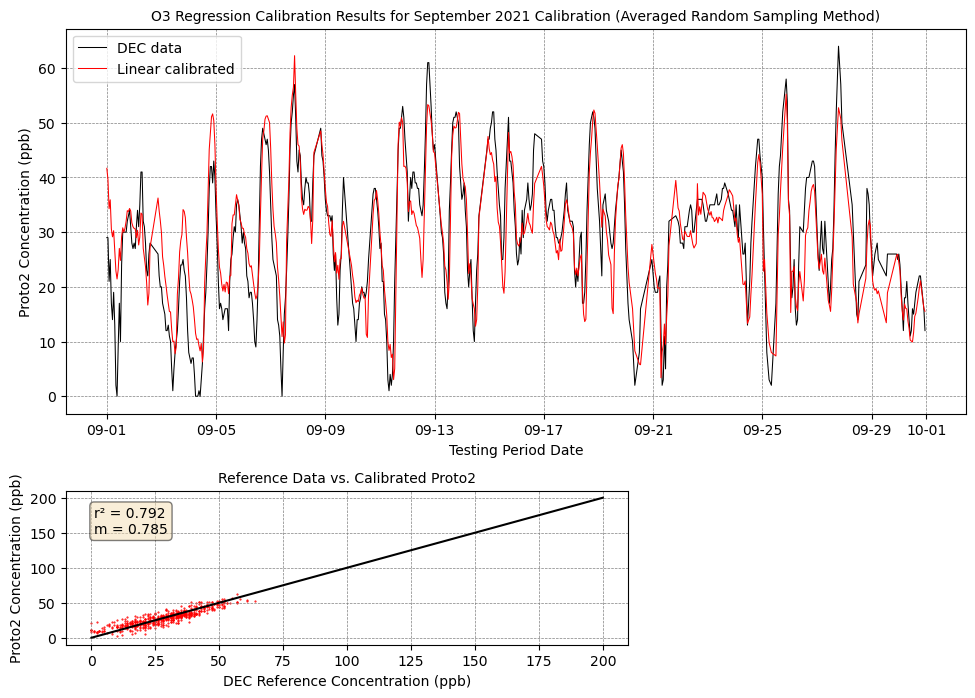

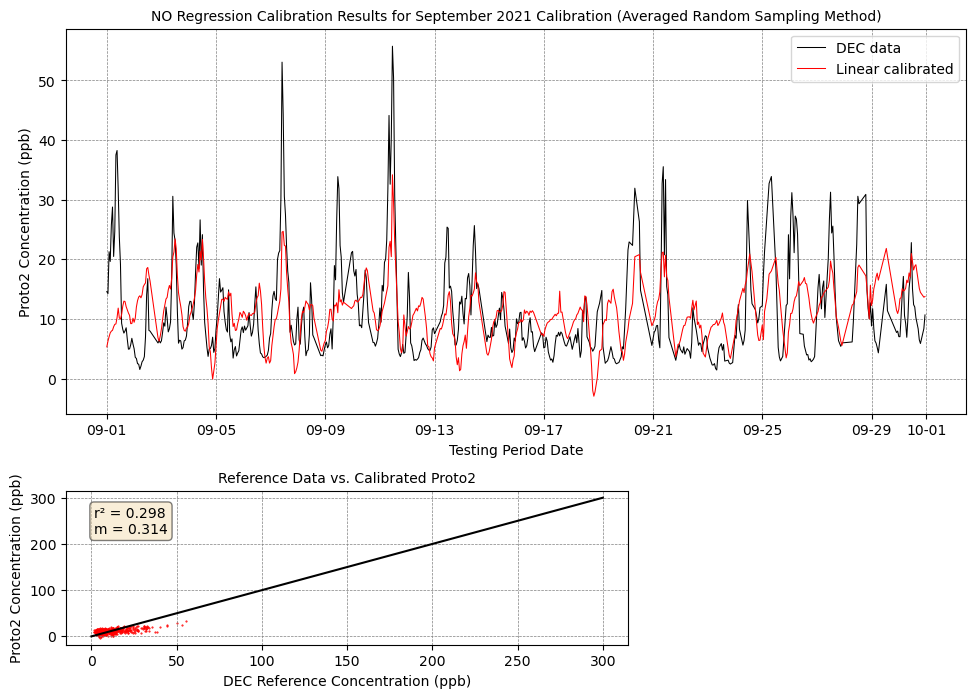

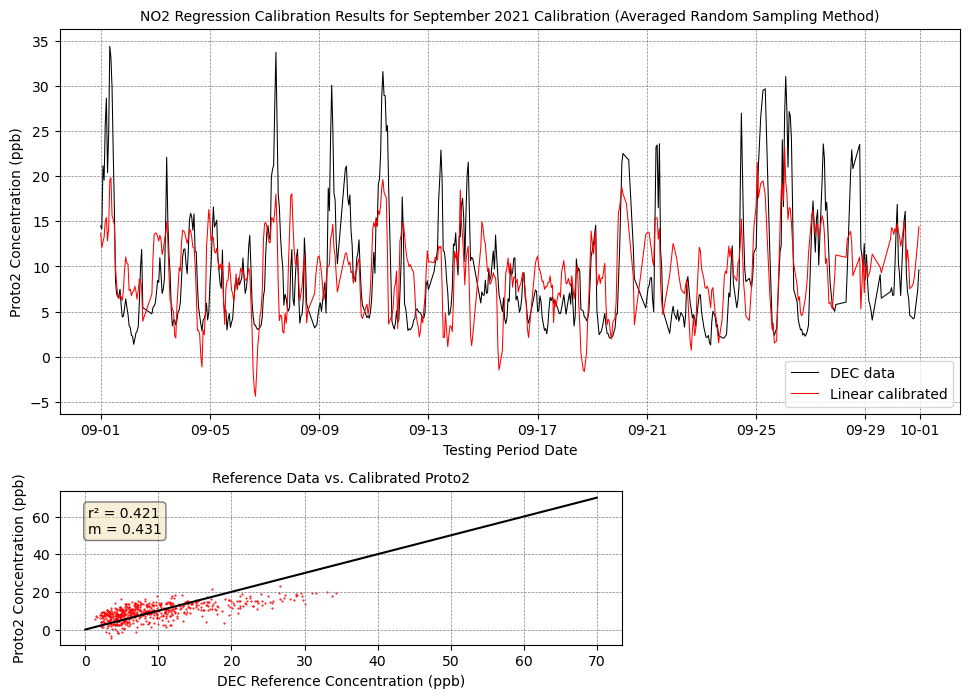

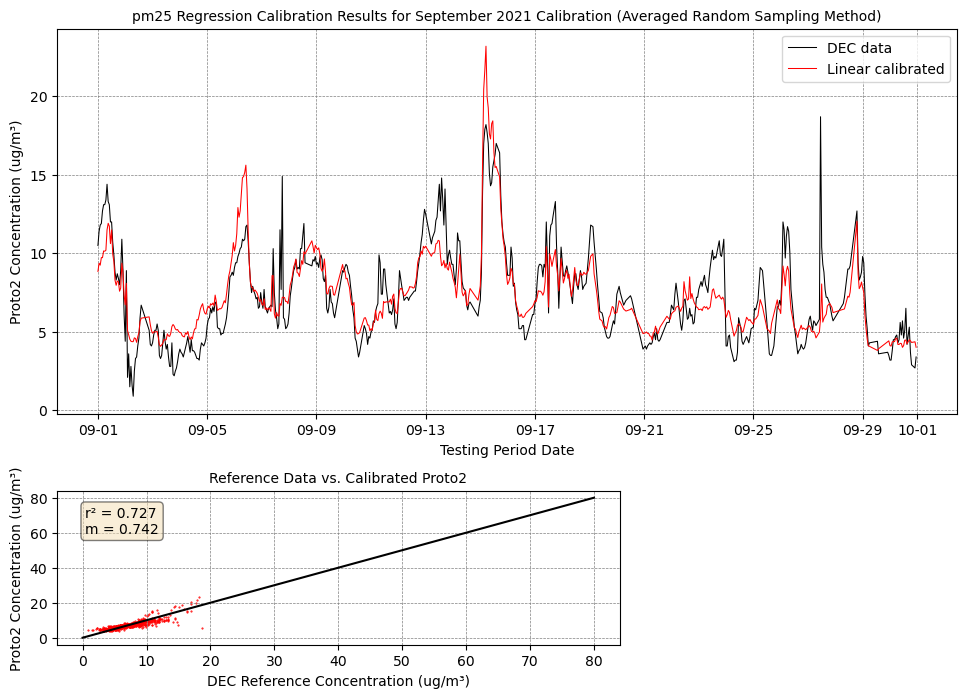

In [41]:
for var_id in [42101, 44201, 42601, 42602, 88101]:
#for var_id in [42101]:
    #for i in range(len(DEC_sept)):
    for i in range(10):

        #get the concentration field that matches the corresponding var_id from observations and convert the time (here it's just a 5 hour conversion)
        epa_concentration_field=DEC_sept[epa_table[var_id]].rename('value')
        #combine the observations and proto2 data into one dataset
        combined_df=pd.concat([epa_concentration_field,proto2_sept_match2DEC],axis=1).dropna()
        #include some checks to see if the field is O3 or pm2.5
        #O3 needs to subtract NO2 because the sensor only records O3NO2
        #pm2.5 has a weird naming convention so this statement catches it and renames it to be consistent
        #basically we're just calculating the voltage difference here
        if var_id==44201:
            combined_df['O3_voltdiff']=(combined_df['O3NO2_V']-combined_df['NO2_V']).sub((combined_df['O3NO2_aux_V']-combined_df['NO2_aux_V']),axis=0)
            gname='O3'
            unit = '_ppb'
            pltunit = 'ppb'
        elif var_id in [88101]:
            gname='pm25'
            combined_df[gname+'_voltdiff']=combined_df[gname+'_std_ugm3'].copy()
            unit='_env_ugm3'
            pltunit = 'ug/m³'
        else:
            fname=proto2_table[str(var_id)]
            gname_loc=fname.find('ppb')-1
            gname=fname[:gname_loc]
            combined_df[gname+'_voltdiff']=combined_df[gname+'_V'].sub(combined_df[gname+'_aux_V'],axis=0)
            unit = '_ppb'
            pltunit = 'ppb'
        #perform some additional last minute qc on the data
        #this just tosses out times where the obs data is weird (i.e. is nan, ==0, ==-999, >10*mean)
        '''
        combined_df_filtered=combined_df.loc[(~np.isnan(combined_df['value'])) & (combined_df['value']>0) 
                                             & (combined_df['value']!=0) & (combined_df['value']!=-999) 
                                             & (abs(combined_df['value'])<(abs(combined_df['value']).mean()*10))]
        '''

         # delineate training and test periods
        combined_df_filtered_training = combined_df.sample(frac=0.5) 
        combined_df_filtered_testing = combined_df.loc[~combined_df.copy().index.isin(combined_df_filtered_training.index)] # selecting data not included in previous random selection aka remaining dates 

        ## training fields using proto2_QC.csv 
        training_reference_concentrations = combined_df_filtered_training['value']
        training_data = [combined_df_filtered_training['temp_sht31_degC'], 
                         combined_df_filtered_training['rh_sht31_percent'], # RH
                         combined_df_filtered_training[gname+'_voltdiff']]

        training_data_input = pd.DataFrame(training_data, index=['Temp','RH','ΔVolt']).transpose()

        # testing fields using proto2_QC.csv 
        testing_reference_concentrations = combined_df_filtered_testing['value']
        testing_data = [combined_df_filtered_testing['temp_sht31_degC'], # T
                        combined_df_filtered_testing['rh_sht31_percent'], # RH
                        combined_df_filtered_testing[gname+'_voltdiff']]

        testing_data_input = pd.DataFrame(testing_data, index=['Temp','RH','ΔVolt']).transpose()

        #print('Working on...', gname)
        coefficients = generate_coefficients(training_data_input,training_reference_concentrations,'linear')    
        calibrated_data = calibrate(coefficients['coef_dict'], testing_data_input)
            
        if i == 0:
            avgdf = pd.DataFrame(calibrated_data)
        else:
            avgdf = pd.concat([avgdf,calibrated_data], axis=1)
            
    training_period_month = str(pd.DatetimeIndex(combined_df_filtered_training.index).month_name()[1])
    testing_period = testing_reference_concentrations.index
    
    ''' stats '''
    
    m = np.polyfit(epa_concentration_field.loc[avgdf.index],avgdf.mean(axis=1),1)
    n = len(epa_concentration_field.loc[avgdf.index])
    r2_testing = (((n*(avgdf.mean(axis=1)*epa_concentration_field.loc[avgdf.index]).sum())-(avgdf.mean(axis=1).sum()*epa_concentration_field.loc[avgdf.index].sum()))\
        /np.sqrt((n*(epa_concentration_field.loc[avgdf.index]**2).sum()-(epa_concentration_field.loc[avgdf.index]).sum()**2)*\
                 (n*(avgdf.mean(axis=1)**2).sum()-avgdf.mean(axis=1).sum()**2)))**2
    
    ''' PLOT TIME :) '''
    print('Plotting for ',gname,'...')
    fig = plt.subplots(figsize=(10,8))
    ''' DEC vs. Calibrated time series plot (top) '''
    time_series = plt.subplot2grid((3, 3), (0, 0), rowspan=2, colspan=3)
    time_series.set_title('time_series')
    time_series.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
    time_series.plot(avgdf.index, epa_concentration_field.loc[avgdf.index],label='DEC data', color='black',linewidth=0.75)
    time_series.plot(avgdf.index,avgdf.mean(axis=1),label='Linear calibrated', color='red',linewidth=0.75)
    time_series.legend()  
    time_series.set_title(gname+' Regression Calibration Results for '+training_period_month+' 2021 Calibration (Averaged Random Sampling Method)', fontsize=10)
    time_series.set_xlabel('Testing Period Date')
    time_series.set_ylabel('Proto2 Concentration ' +'('+pltunit+')') 
    time_series.xaxis.set_major_formatter(DateFormatter('%m-%d'))
    
    ''' DEC vs. Calibrated trend  plot (bottom left) '''
    data_series = plt.subplot2grid((3, 3), (2, 0), colspan=2)
    data_series.set_title('data_series')
    data_series.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
    # 1:1 line
    if var_id==42101: # CO
        xmax = 2000
    if var_id==44201: # O3
        xmax = 200
    if var_id==42601: # NO
        xmax = 300
    if var_id==42602: # N02
        xmax = 70
    if var_id==88101: # pm25
        xmax = 80 
    ymax=xmax
    point1 = [0,0]
    point2 = [xmax,ymax]
    x_values = [point1[0], point2[0]]
    y_values = [point1[1], point2[1]]
    data_series.plot(x_values, y_values, color='black', label='1:1 Line')
    # plotting data... 
    data_series.scatter(epa_concentration_field.loc[avgdf.index],avgdf.mean(axis=1),color='red',s=0.25)
    data_series.set_xlabel('DEC Reference Concentration '+'('+pltunit+')')
    data_series.set_ylabel('Proto2 Concentration ' +'('+pltunit+')')
    data_series.set_title('Reference Data vs. Calibrated Proto2', fontsize=10)
    data_series.text(0.05, 0.90, 'r² = '+str(r2_testing.round(3))+'\nm = '+str(m[0].round(3)), 
                     transform=data_series.transAxes, fontsize=10,verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    plt.subplots_adjust(left=0, wspace=0.50, hspace=0.50)
    
    
    figname = str(gname+'_'+training_period_month+'_avgrandsamp_analysis')
    print('Saving figure as...',figname)
    filepath = '/data/shared/ehojeily/september_analysis/'
    #plt.savefig(filepath+figname+'.png',bbox_inches='tight',dpi=300)
    
    '''
    with open(filepath+'readme.txt', 'w') as f:
        f.write('Proto2 calibration analysis plots using generate_coefficients and calibrate function. \n Script used: pvalue_draft2.ipynb')
    '''
    print('\n')